In [82]:
from openai import OpenAI, pydantic_function_tool

client = OpenAI(api_key = API_KEY)
# completion = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {"role": "user", "content": "こんにちは"}
#     ]
# )

In [47]:
from pydantic import BaseModel

class Country(BaseModel):
    name: str
    answer: str


In [48]:
completion = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "あなたは優秀な歴史学者であり、地政学者です。ユーザーの質問に対して、G20の各国について、それぞれ簡潔に答えてください。情報の無い国については、「分からない」という説明にして必ず20カ国全ての国について説明してください。"},
        {"role": "user", "content": "気候変動の影響について教えてください。"},
    ],
    tools=[pydantic_function_tool(Country)],
)

In [49]:
print(completion.choices[0].message)

ParsedChatCompletionMessage[NoneType](content='G20は20の経済大国からなるグループであり、それぞれの国が気候変動の影響を異なった方法で受けています。これらの影響や対策について簡潔に説明します。', refusal=None, role='assistant', function_call=None, tool_calls=[ParsedFunctionToolCall(id='call_bEJRaF7QyPhdjmTKyfQan6mV', function=ParsedFunction(arguments='{"name": "アルゼンチン", "answer": "アルゼンチンは干ばつや洪水などの異常気象が頻発しており、農業生産に深刻な影響を与えています。気候変動に対する適応と緩和策が求められています。"}', name='Country', parsed_arguments=Country(name='アルゼンチン', answer='アルゼンチンは干ばつや洪水などの異常気象が頻発しており、農業生産に深刻な影響を与えています。気候変動に対する適応と緩和策が求められています。')), type='function'), ParsedFunctionToolCall(id='call_YTD1jkO29YECeS30yUAlUxBp', function=ParsedFunction(arguments='{"name": "オーストラリア", "answer": "オーストラリアは干ばつ、森林火災、そして海面上昇による沿岸地域の浸水といった気候変動の影響を受けています。特に2020年の森林火災は大規模で壊滅的な被害をもたらしました。"}', name='Country', parsed_arguments=Country(name='オーストラリア', answer='オーストラリアは干ばつ、森林火災、そして海面上昇による沿岸地域の浸水といった気候変動の影響を受けています。特に2020年の森林火災は大規模で壊滅的な被害をもたらしました。')), type='function'), ParsedFunctionToolCall(id='call_mok4yWijmLyFf0DlF3v7Sccm', function=

In [51]:
print(len(completion.choices[0].message.tool_calls))
print(type(completion.choices[0].message))
print(type(completion.choices[0].message.tool_calls))


20
<class 'openai.types.chat.parsed_chat_completion.ParsedChatCompletionMessage[NoneType]'>
<class 'list'>


In [52]:
texts = list(map(lambda x: x.function.parsed_arguments.answer, completion.choices[0].message.tool_calls))
print(texts)

['アルゼンチンは干ばつや洪水などの異常気象が頻発しており、農業生産に深刻な影響を与えています。気候変動に対する適応と緩和策が求められています。', 'オーストラリアは干ばつ、森林火災、そして海面上昇による沿岸地域の浸水といった気候変動の影響を受けています。特に2020年の森林火災は大規模で壊滅的な被害をもたらしました。', 'アマゾン熱帯雨林の減少、干ばつ、重要な河川の枯渇など、ブラジルは気候変動の深刻な影響を受けています。森林保護と持続可能な農業が課題です。', 'カナダでは氷河の融解、森林火災の増加、極端な気温の上昇などが報告されています。北極圏の温暖化は特に顕著です。', '中国は大規模な都市化と工業化により、深刻な大気汚染や水不足が懸念されます。また、洪水や砂漠の拡大といった自然災害も頻発しています。', 'フランスは気候変動に対する対策として、再生可能エネルギーの推進や温室効果ガスの排出削減を進めています。熱波や洪水の頻度が増加しています。', 'ドイツでは異常気象や洪水などが増加しており、再生可能エネルギーの利用拡大と炭素排出削減の取り組みが進められています。', 'インドは極端な気候現象に頻繁に直面しており、特に熱波、洪水、干ばつが深刻です。食料安全保障や水資源管理が重要な課題となっています。', 'インドネシアでは、森林火災や海面上昇、洪水が主要な問題です。特に自治体の洪水対策と環境保護が重要です。', 'イタリアは熱波や洪水、海面上昇の影響を受けています。特にベネチアでは洪水対策が急務です。再生可能エネルギーの推進が進んでいます。', '日本では台風の強化や頻発、豪雨による洪水、猛暑などが増加しており、これに対する適応策が必要です。再生可能エネルギーの導入が進んでいます。', '韓国は気候変動により、熱波や豪雨の頻度が増加しています。温室効果ガスの削減とエネルギー効率の向上を目指しています。', 'メキシコでは干ばつや洪水、熱波が主要な問題であり、これに対する警戒が必要です。持続可能な都市開発と農業が課題です。', 'ロシアでは永久凍土の融解、森林火災の増加、極端な寒暖差といった形で気候変動の影響が現れています。炭素排出削減の取り組みが課題です。', 'サウジアラビアは極端な暑さと水不足が深刻です。再生可能エネルギーの導入と水資源管理が重要です。

In [59]:
embedding = client.embeddings.create(input = texts, model="text-embedding-3-small", dimensions=512)
vectors = list(map(lambda x: x.embedding, embedding.data))
print(vectors)

[[0.015075220726430416, -0.0018434373196214437, 0.06057398393750191, 0.005308416672050953, -0.00023149646585807204, 0.06576292216777802, 0.03607675060629845, 0.043505121022462845, -0.03820694610476494, -0.05330947786569595, -0.05702366307377815, 0.009346909821033478, -0.11240871250629425, -0.004963625688105822, -0.06226721778512001, 0.029931960627436638, 0.017451206222176552, -0.024988817051053047, -0.056258976459503174, 0.05309099704027176, -0.02916727587580681, 0.010835315100848675, -0.09635032713413239, -0.02224414423108101, 0.006049205549061298, 0.019581401720643044, 0.002609829418361187, 0.0829683318734169, 0.03995479643344879, -0.051643554121255875, 0.07652313262224197, -0.03271760046482086, -0.011518069542944431, 0.010104767978191376, -0.005806827452033758, 0.06390582770109177, 0.0007809005328454077, -0.013975986279547215, 0.017150795087218285, -0.031188229098916054, -0.0004817686858586967, -0.02557598613202572, 0.02012760378420353, 0.0507696308195591, -0.0396270751953125, 0.114

In [79]:
import umap

#上手く行かなかったら以下でリトライ
#import umap.umap_ as umap

reducer = umap.UMAP(n_components=3)
res = reducer.fit_transform(vectors)
print(res)


[[11.149253   9.534517   6.321268 ]
 [10.3935585  8.616944   5.73656  ]
 [10.596415   9.707118   6.217057 ]
 [ 9.753964   9.232068   5.393969 ]
 [10.883339   9.298822   5.432868 ]
 [10.548243   8.307905   4.594738 ]
 [ 9.959405   8.710331   4.007986 ]
 [11.829597   9.52131    5.257082 ]
 [11.346878   9.8119955  5.252634 ]
 [10.468184   9.199267   4.072178 ]
 [11.2796135  8.377045   4.166198 ]
 [10.697674   8.0167675  4.0866313]
 [11.5101595  9.105081   5.7192035]
 [ 9.567689   8.950741   4.954132 ]
 [11.337392   9.34771    4.181998 ]
 [11.090337  10.049211   6.093878 ]
 [11.020055   8.9853     3.6736264]
 [11.082707   8.220828   5.267933 ]
 [ 9.930075   9.389631   4.4927015]
 [10.183971   7.846144   4.4317217]]


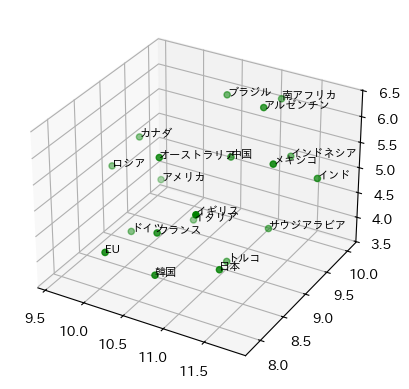

In [81]:
import matplotlib.pyplot as plt
import matplotlib_fontja

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(res[:, 0], res[:, 1], res[:, 2], color='green')

# 各点にラベルを表示
countries = list(map(lambda x: x.function.parsed_arguments.name, completion.choices[0].message.tool_calls))
for i, name in enumerate(countries):
    ax.text(res[i, 0], res[i, 1], res[i, 2], name, fontsize=8)

plt.show()

# # UMAPの結果を2次元プロット
# plt.scatter(res[:, 0], res[:, 1], s=5, c='blue')

# # 各点にラベルを表示
# countries = list(map(lambda x: x.function.parsed_arguments.name, completion.choices[0].message.tool_calls))
# for i, name in enumerate(countries):
#     plt.annotate(name, (res[i, 0], res[i, 1]), fontsize=8)

plt.show()
